In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.feature_selection import r_regression

base = "data_max_integration_time/"

UV = "UV/"
VIS = "VIS/"
IR = "IR/"
NO_LED = "NO_LED/"

types = [
    {
        "path": UV,
        "name": "UV"
    },
    {
        "path": VIS,
        "name": "VIS"
    },
    {
        "path": IR,
        "name": "IR"
    },
    # {
    #     "path": NO_LED,
    #     "name": "NO_LED"
    # }
]

channels = ["410nm", "435nm", "460nm", "485nm", "510nm", "535nm", "560nm","585nm","610nm","645nm","680nm","705nm","730nm","760nm","810nm","860nm","900nm","940nm"]

exclude_files = [] #  ["19.csv", "13.csv", "38.csv"]

In [6]:
ranges = {}

for type in types:
    
    filepath = base + type["path"]
    files = os.listdir(filepath)
    
    maxes = mins = None
    
    for file in files:
        
        if file in exclude_files:
            continue
        
        with open(filepath + file, "r") as f:
            content = f.readlines()
            entries = content[0:-1]
            glucose_concentration = float(content[-1].replace("glucose_concentration:", "").replace("\n", ""))
            
            value = [np.fromstring(entry.replace("\n", ""), sep="|") for entry in entries]
            value = np.concatenate(value, axis=0).reshape(2, -1).mean(axis=0)
            
            maxes = value if maxes is None else np.maximum(maxes, value)
            mins = value if mins is None else np.minimum(mins, value)
            
    diffs = maxes - mins
    # ranges[type["name"]] = np.ceil(np.max(diffs)) / 2
    
    ranges[type["name"]] = np.ceil(diffs) / 2
    
    # print(diffs)
                
print(ranges)

{'UV': array([1169.5,  190.5,   31.5,   19. ,   13.5,    8.5,   10.5,    7. ,
         11.5,    6. ,    2.5,    3. ,    1.5,    9. ,    1.5,    1.5,
          2. ,    2. ,    1.5]), 'VIS': array([4.52000e+02, 3.75400e+03, 1.02595e+04, 3.63150e+03, 7.50050e+03,
       1.02350e+04, 6.23500e+02, 7.04000e+02, 7.84500e+02, 2.14500e+02,
       3.85000e+01, 4.10000e+01, 1.35225e+04, 3.85450e+03, 1.09000e+03,
       6.62000e+02, 9.09500e+02, 4.88500e+02, 1.50000e+00]), 'IR': array([2.7500e+01, 3.2000e+01, 2.2000e+01, 1.8000e+01, 1.9000e+01,
       1.3500e+01, 8.0000e+01, 1.0150e+02, 4.1000e+01, 6.7500e+01,
       3.0365e+03, 1.3080e+03, 5.0000e+01, 7.6500e+01, 9.5000e+01,
       1.5500e+02, 2.3570e+03, 6.3000e+03, 2.0000e+00])}


### LED on: UV

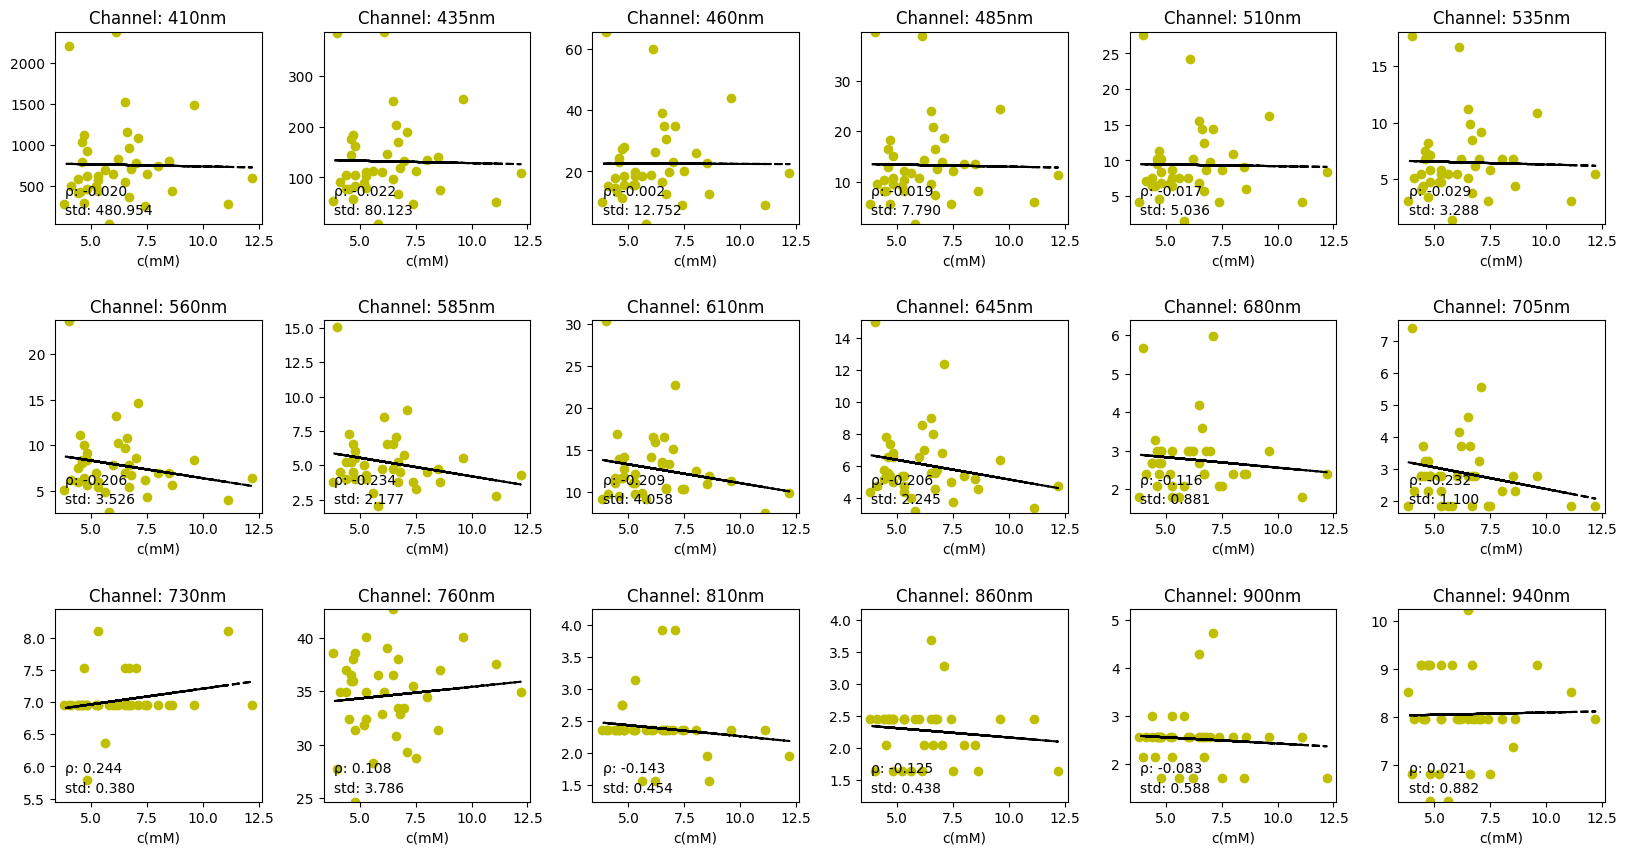

### LED on: VIS

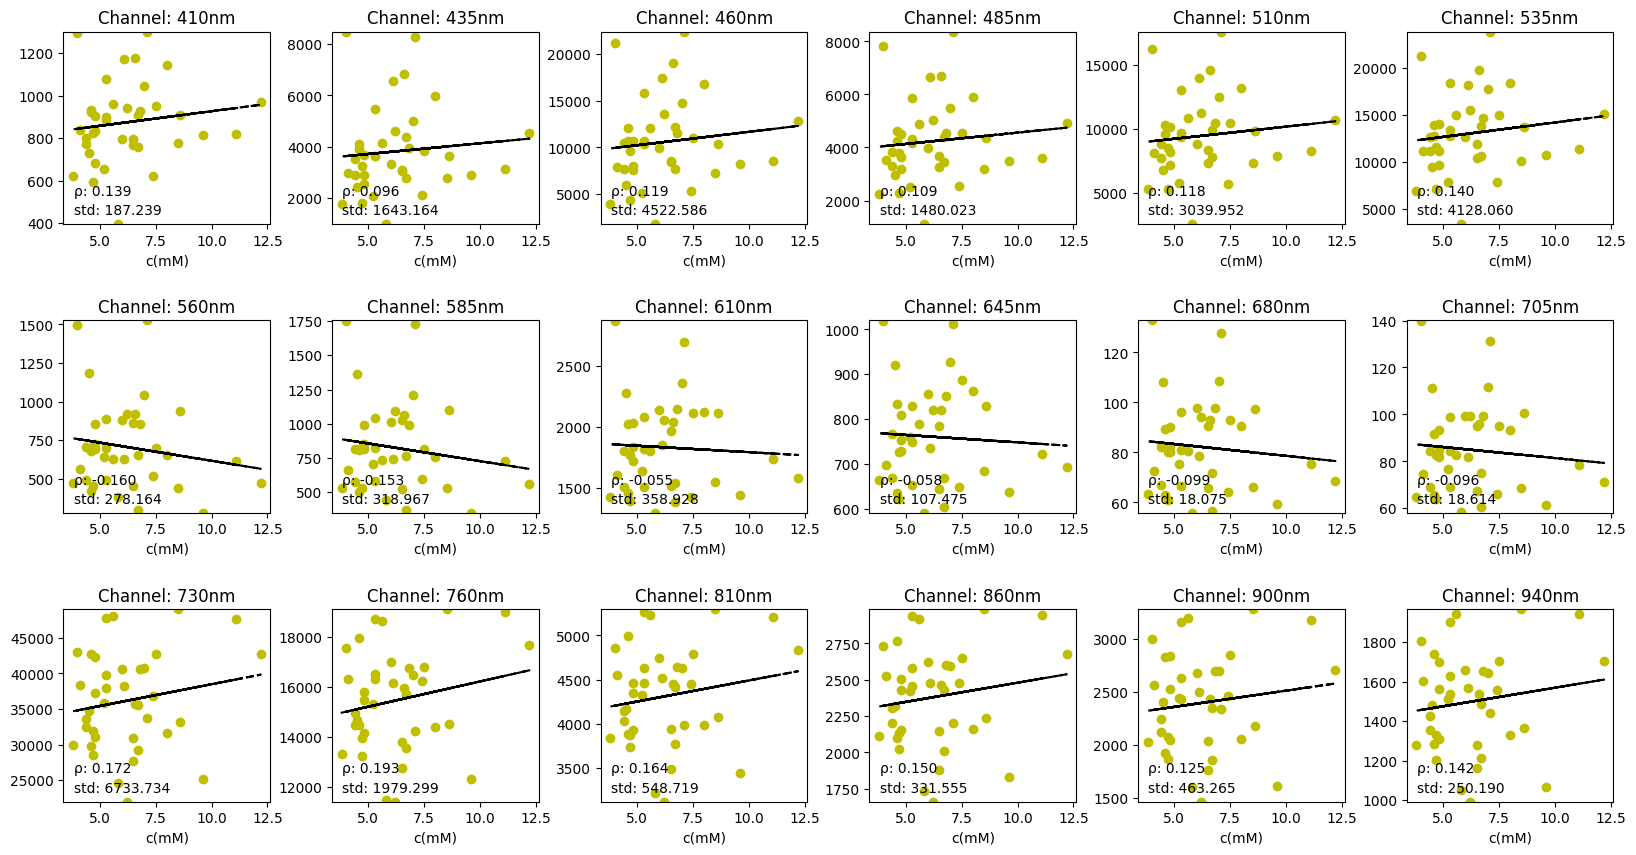

### LED on: IR

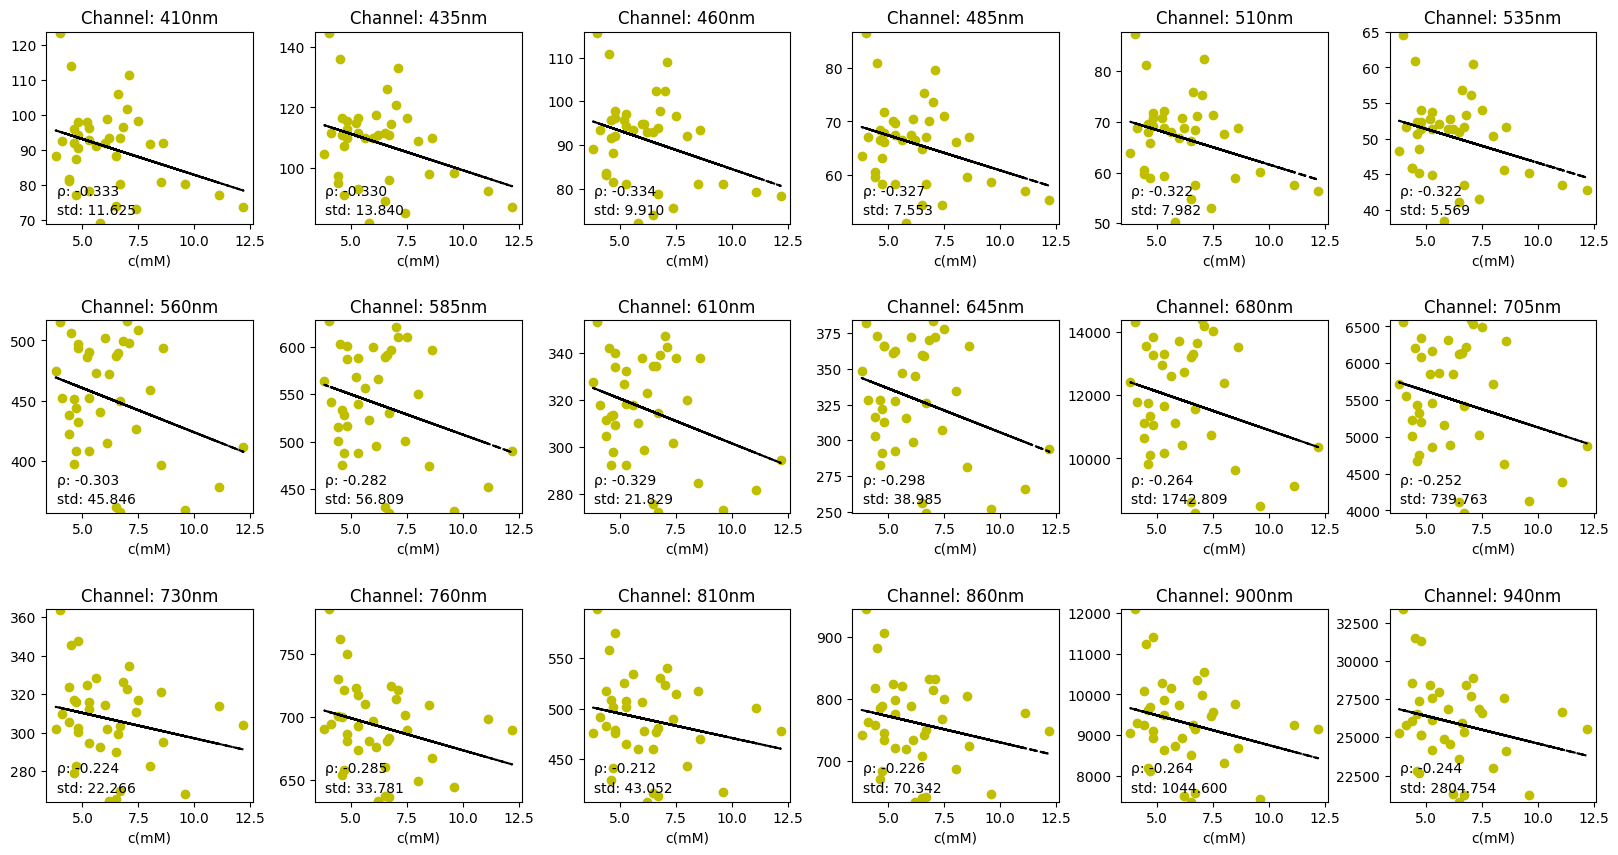

In [7]:
for type in types:
    display(Markdown(f"### LED on: {type['name']}"))
    
    filepath = base + type["path"]
    files = os.listdir(filepath)
    
    x = y = None
    maxes = mins = None    
    
    linreg = [[[], []] for _ in range(len(channels))]
    
    for file in files:
        
        if file in exclude_files:
            continue
        
        with open(filepath + file, "r") as f:
            content = f.readlines()
            entries = content[0:-1]
            glucose_concentration = float(content[-1].replace("glucose_concentration:", "").replace("\n", ""))
            
            value = [np.fromstring(entry.replace("\n", ""), sep="|") for entry in entries]
            value = np.concatenate(value, axis=0).reshape(2, -1).mean(axis=0)
            
            x = np.array([glucose_concentration]) if x is None else np.append(x, glucose_concentration)
            y = value if y is None else np.vstack((y, value))
            
            maxes = value if maxes is None else np.maximum(maxes, value)
            mins = value if mins is None else np.minimum(mins, value)
            
    plt.figure(figsize=(20, 10)) # for presentation
    # plt.figure(figsize=(12, 15)) # for written report
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    for ix, channel in enumerate(channels):
        
        plt.subplot(3, 6, ix + 1) # for presentation
        # plt.subplot(6, 3, ix + 1) # for written report
                
        plt.title(f"Channel: {channels[ix]}")
        plt.xlabel("c(mM)")
        
        mean = maxes[ix] - (maxes[ix] - mins[ix]) / 2
        # plt.ylim(mean - ranges[type["name"]], mean + ranges[type["name"]])
        
        plt.ylim(mean - ranges[type["name"]][ix], mean + ranges[type["name"]][ix])
        
        plt.plot(x, y[:, ix], 'yo')
        
        linreg[ix][0] = x
        linreg[ix][1] = y[:, ix]
        
    for ix in range(len(channels)):
        x = linreg[ix][0]
        y = linreg[ix][1]
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef) 
        
        plt.subplot(3, 6, ix + 1) # for presentation
        # plt.subplot(6, 3, ix + 1) # for written report
                
        plt.plot(x, poly1d_fn(x), '--k')
        
    for ix in range(len(channels)):
        x = np.array(linreg[ix][0])
        y = np.array(linreg[ix][1])
        r = r_regression(y.reshape(-1, 1), x)
        
        ax = plt.subplot(3, 6, ix + 1) # for presentation
        # ax = plt.subplot(6, 3, ix + 1) # for written report
        
        plt.text(0.05, 0.15, f'ρ: {r.item():.3f}', transform=ax.transAxes)
        plt.text(0.05, 0.05, f'std: {y.std():.3f}', transform=ax.transAxes)
        
    plt.savefig(f'screens_subplots/{type["name"]}.png', bbox_inches='tight', pad_inches=0.1)
            
    plt.show()

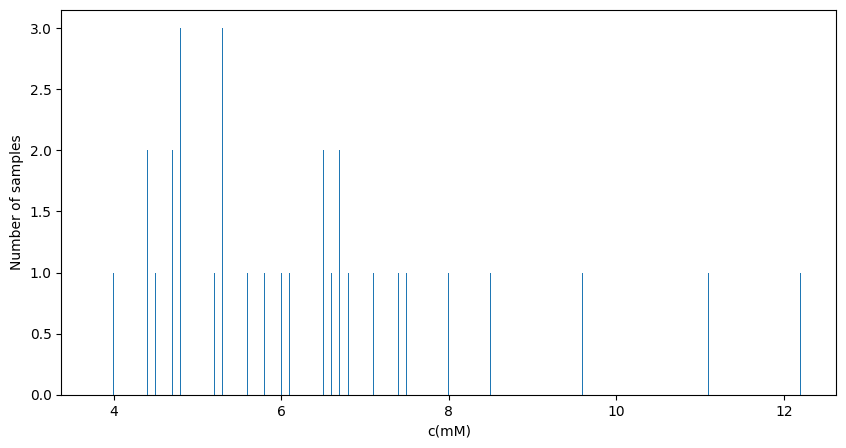

In [22]:
filepath = base + types[0]["path"]
files = os.listdir(filepath)

concentrations = {}

y = None 

for file in files:
    
    if file in exclude_files:
        continue
    
    with open(filepath + file, "r") as f:
        content = f.readlines()
        glucose_concentration = float(content[-1].replace("glucose_concentration:", "").replace("\n", ""))
        
        if glucose_concentration not in concentrations:
            concentrations[glucose_concentration] = 1
        else:
            concentrations[glucose_concentration] += 1
            
plt.figure(figsize=(10, 5))
plt.bar(concentrations.keys(), concentrations.values(), width=0.01)

plt.xlabel("c(mM)")
plt.ylabel("Number of samples")

plt.show()

In [17]:
for type in types:
    
    filepath = base + type["path"]
    files = os.listdir(filepath)
    
    x = y = None
    maxes = mins = None    
    
    linreg = [[[], []] for _ in range(len(channels))]
    
    for file in files:
        
        if file in exclude_files:
            continue
        
        with open(filepath + file, "r") as f:
            content = f.readlines()
            entries = content[0:-1]
            glucose_concentration = float(content[-1].replace("glucose_concentration:", "").replace("\n", ""))
            
            value = [np.fromstring(entry.replace("\n", ""), sep="|") for entry in entries]
            value = np.concatenate(value, axis=0).reshape(2, -1).mean(axis=0)
            
            x = np.array([glucose_concentration]) if x is None else np.append(x, glucose_concentration)
            y = value if y is None else np.vstack((y, value))
            
            maxes = value if maxes is None else np.maximum(maxes, value)
            mins = value if mins is None else np.minimum(mins, value)
    
    for ix, channel in enumerate(channels):
        
        plt.figure(figsize=(10, 10))
        
        plt.title(f"Channel: {channels[ix]}")
        plt.xlabel("c(mM)")
        
        mean = maxes[ix] - (maxes[ix] - mins[ix]) / 2
        plt.ylim(mean - ranges[type["name"]], mean + ranges[type["name"]])
        
        plt.plot(x, y[:, ix], 'yo')
        
        coef = np.polyfit(x, y[:, ix], 1)
        poly1d_fn = np.poly1d(coef) 

        plt.plot(x, poly1d_fn(x), '--k')
        
        plt.savefig(f'screens/{type["name"]}-{channel}.png')
        
        plt.close()